In [1]:

# --- Set cores and seed ---
import os
N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"

# --- Import Libraries ---
import jax.numpy as jnp
import jax

print(jax.devices(), jax.device_count())

import pandas as pd
import numpy as np
import pyreadr

from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.optim import ClippedAdam
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, AutoNormal
import numpyro.distributions as dist
import numpyro

import matplotlib.pyplot as plt

import src.utils as utils

import Data.Palluck_et_al.data_wrangle as dw



[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)] 4


In [2]:
all_schools = pyreadr.read_r('Data/Palluck_et_al/37070-0001-Data.rda')
all_schools = pd.DataFrame(all_schools['da37070.0001'])

df_cleaned = dw.clean_data(all_schools)

print(df_cleaned.shape)
print(df_cleaned.columns)

(24182, 49)
Index(['SCHID', 'SCHTREAT_NUMERIC', 'TREAT_NUMERIC', 'unique_id', 'ELIGIBLE',
       'WRISTOW2_NUMERIC', 'ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7',
       'ST8', 'ST9', 'ST10', 'ST1W2', 'ST2W2', 'ST3W2', 'ST4W2', 'ST5W2',
       'ST6W2', 'ST7W2', 'ST8W2', 'ST9W2', 'ST10W2', 'BF1', 'BF2', 'BF1W2',
       'BF2W2', 'GENC', 'ETHW', 'ETHB', 'ETHH', 'ETHA', 'ETHC', 'ETHSA',
       'MOVE', 'ACTSS', 'ACTSO', 'ACTM', 'ACTT', 'ACTC', 'ACTR', 'TOMESG',
       'GAME', 'GRC_6', 'GRC_7', 'GRC_8'],
      dtype='object')


In [3]:
df_cleaned

,SCHID,SCHTREAT_NUMERIC,TREAT_NUMERIC,unique_id,ELIGIBLE,WRISTOW2_NUMERIC,ST1,ST2,ST3,ST4,...,ACTSO,ACTM,ACTT,ACTC,ACTR,TOMESG,GAME,GRC_6,GRC_7,GRC_8
0,1.0,1,0,1001,0,0,12.0,999.0,140.0,13.0,...,1,0,0,0,1,0,1,1,0,0
1,1.0,1,2,1002,1,0,21.0,31.0,7.0,20.0,...,0,0,0,0,1,0,1,1,0,0
2,1.0,1,0,1003,0,0,999.0,1.0,45.0,20.0,...,1,0,1,0,0,0,1,1,0,0
3,1.0,1,0,1004,0,1,19.0,24.0,32.0,22.0,...,1,1,0,1,0,0,1,1,0,0
4,1.0,1,0,1005,0,0,258.0,10.0,4.0,32.0,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24466,60.0,1,0,60670,0,0,508.0,470.0,405.0,631.0,...,0,1,0,0,0,0,1,0,0,1
24467,60.0,1,0,60671,0,0,194.0,519.0,520.0,NaN,...,0,0,0,0,1,0,1,0,0,1
24468,60.0,1,0,60672,0,0,28.0,161.0,263.0,174.0,...,1,0,0,1,0,0,1,0,0,1
24469,60.0,1,0,60673,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0


In [4]:
df_cleaned["SCHID"].unique()

array([ 1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 53., 55., 56.,
       57., 58., 59., 60.])

In [5]:
# test one school

# df_min = df_cleaned[df_cleaned['SCHID'] == 41.0]
df_min = df_cleaned[df_cleaned['SCHID'].isin([6.0, 41.0,49.0, 51.0])]
df_min["schid_s"] = dw.transform_schid(jnp.array(df_min["SCHID"].values))
# df_min = df_cleaned[df_cleaned['SCHID'] == 49.0]
print(df_min.shape)

(1923, 50)


C:\Users\bar21\AppData\Local\Temp\ipykernel_18972\3619171552.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min["schid_s"] = dw.transform_schid(jnp.array(df_min["SCHID"].values))


In [6]:
data_dict = dw.data_for_network_analysis(df_min)
# data_dict = dw.data_for_network_analysis(df_cleaned)
# print(df_data.keys())
print(data_dict)


triu_data = dw.network_triu_multiple_schools(df_min)
print(triu_data.keys())

print(triu_data["ST_triu"].shape, triu_data["ij_indices"].shape)

data_dict = data_dict | triu_data



{'n_schools': 4, 'n_nodes_sch': array([464, 503, 409, 547], dtype=int64), 'offsets': Array([   0,  464,  967, 1376], dtype=int32), 'total_n': 1923, 'total_edges_list': array([107416, 126253,  83436, 149331], dtype=int64), 'total_edges_sum': 466436, 'schid_s': Array([0, 0, 0, ..., 3, 3, 3], dtype=int32)}
dict_keys(['ST_triu', 'STW2_triu', 'BF_triu', 'BFW2_triu', 'ij_indices'])
(466436,) (466436, 2)


In [7]:
%%time 
# df_min_net_cov = cov_for_net(df_min, NODE_COV)
df_min_net_cov = dw.cov_for_net(df_min, dw.COV_FOR_NETWORK)

print(df_min_net_cov.shape, df_min_net_cov.dtype, type(df_min_net_cov))

data_dict["cov"] = jnp.array(df_min_net_cov)

(466436, 12) float32 <class 'jaxlib.xla_extension.ArrayImpl'>
CPU times: total: 5.62 s
Wall time: 5.97 s


In [8]:
print(data_dict["ST_triu"].shape, data_dict["STW2_triu"].shape, data_dict["BF_triu"].shape, data_dict["BFW2_triu"].shape)



(466436,) (466436,) (466436,) (466436,)


In [9]:
data_dict["schid_edges"] = dw.school_id_by_edge(data_dict)
print(data_dict["schid_edges"].shape, "\n",
      jnp.unique_counts(data_dict["offsets"][data_dict["schid_edges"]]), "\n",
      data_dict["offsets"][data_dict["schid_edges"]].shape)

(466436,) 
 _UniqueCountsResult(values=Array([   0,  464,  967, 1376], dtype=int32), counts=Array([107416, 126253,  83436, 149331], dtype=int32)) 
 (466436,)


In [10]:
data_dict["schid_edges"]

Array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
PRIOR_SCALE = jnp.sqrt(5.0)

def networks_marg_multi_school(data):
    """
    A fully vectorized multi-school network model in NumPyro.
    Marginalizes out A^1 edges, and uses advanced indexing to 
    avoid Python loops.

    Args:
        data: dict with the following minimal fields
          - 'n_schools': S (int)
          - 'n_nodes_sch': shape [S] 
          - 'offsets': shape [S] (the start index for each school in the concatenated node array)
          - 'total_n': total # of nodes across all schools
          - 'schid_edges': shape [E], school ID for each edge
          - 'ij_indices': shape (E, 2), local indices (i,j) in that school
          - 'cov': shape [E, n_cov], covariates for each edge
          - 'STW2_triu': shape [E], the observed edges A^2_{ij} in upper triangle
    """

    # -------------------------------------------------------
    #  1. Global parameters shared across all schools
    # -------------------------------------------------------
    n_covs = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0.0, PRIOR_SCALE).expand([n_covs]))
    # gamma = numpyro.sample("gamma", dist.Normal(0.0, PRIOR_SCALE).expand([2*n_covs]))
    # gamma = numpyro.sample("gamma", dist.Normal(0.0, PRIOR_SCALE).expand([2]))

   

    # -------------------------------------------------------
    #  2. School-level random intercepts
    # -------------------------------------------------------
    # alpha = numpyro.sample("alpha", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))
    alpha_sigma = numpyro.sample("alpha_sigma", dist.Normal(3.0))
    alpha_sc = numpyro.sample("alpha_sc", dist.Normal(0.0, 1.0).expand([data["n_schools"]]))
    alpha = numpyro.deterministic("alpha", alpha_sc * alpha_sigma)
    # or for hierarchical modeling, you could do something like:
    # sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfCauchy(1.0))
    # alpha = numpyro.sample("alpha", dist.Normal(0.0, sigma_alpha).expand([S]))

    # -------------------------------------------------------
    #  3. Node-level latent positions, all schools concatenated
    # -------------------------------------------------------

    with numpyro.plate("all_nodes", data["total_n"]):
        # 1D array of length total_n
        u_all = numpyro.sample("u_all", dist.Normal(0.0, 1.0))

    # -------------------------------------------------------
    #  4. Compute star_probs = P(A^1_{ij}=1) for each edge
    # -------------------------------------------------------
    E = data["STW2_triu"].shape[0]  # total edges stacked

    # We can compute "global" node indices for each edge in a vectorized manner:
    #   global_i[e] = offsets[schid[e]] + i_idx[e]
    #   global_j[e] = offsets[schid[e]] + j_idx[e]
    global_i = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 0]
    global_j = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 1]

    # The distance in latent space for edge e:
    #   dist_term[e] = | u_all[global_i[e]] - u_all[global_j[e]] |
    u_i = u_all[global_i]
    u_j = u_all[global_j]
    u_norm = jnp.abs(u_i - u_j)

    # The linear covariate predictor for edge e:
    #   cov_term[e] = dot(cov[e,:], theta)
    # cov_term = jnp.einsum('ed,d->e', data["cov"], theta)  # shape (E,)
    cov_term = jnp.dot(data["cov"], theta)

    # The school random intercept: alpha_term[e] = alpha[ schid[e] ]
    alpha_term = alpha[data["schid_edges"]]

    # Now combine them into the logit
    star_logit = alpha_term + cov_term - u_norm 
    star_probs = jax.nn.sigmoid(star_logit)  # shape (E,)
    star_probs = jnp.clip(star_probs, a_min=1e-6, a_max=1.0 - 1e-6)

    alpha_gamma_0 = numpyro.sample("alpha_gamma_0", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))
    alpha_gamma_1 = numpyro.sample("alpha_gamma_1", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))

    alpha_gamma_0_term = alpha_gamma_0[data["schid_edges"]]
    alpha_gamma_1_term = alpha_gamma_1[data["schid_edges"]]


    obs_prob_k0 = jax.nn.sigmoid(alpha_gamma_0_term)  # P(A^STW2=1 | A^ST=0)
    # obs_prob_k0 = jax.nn.sigmoid(gamma[0])  # P(A^STW2=1 | A^ST=0)
    obs_prob_k0 = jnp.clip(obs_prob_k0, a_min=1e-6, a_max=1.0 - 1e-6)
    obs_prob_k1 = jax.nn.sigmoid(alpha_gamma_1_term)  # P(A^STW2=1 | A^ST=1)
    # obs_prob_k1 = jax.nn.sigmoid(gamma[1])  # P(A^STW2=1 | A^ST=1)
    obs_prob_k1 = jnp.clip(obs_prob_k1, a_min=1e-6, a_max=1.0 - 1e-6)

    # -------------------------------------------------------
    #  5. Marginal likelihood for the observed edges A^2
    #     P(A^2=1) = star_probs*obs_prob_k1 + (1 - star_probs)*obs_prob_k0
    # -------------------------------------------------------
    mixed_probs = star_probs * obs_prob_k1 + (1.0 - star_probs) * obs_prob_k0

    with numpyro.plate("edges", E):
        numpyro.sample("obs", dist.BernoulliProbs(mixed_probs), obs=data["STW2_triu"])

    # -------------------------------------------------------
    #  6. Posterior of A^1_{ij} for diagnostic (optional)
    # -------------------------------------------------------
    # posterior_A1_probs[e] = P(A^1=1 | A^2, params).
    #   numerator = star_probs[e]*{obs_prob_k1 if A^2=1 else 1 - obs_prob_k1}
    #   denominator = numerator + (1 - star_probs[e])*{obs_prob_k0 if A^2=1 else 1 - obs_prob_k0}
    at2 = data["STW2_triu"]  # shape (E,)
    numerator_1 = jnp.where(
        at2 == 1.0,
        star_probs * obs_prob_k1,
        star_probs * (1.0 - obs_prob_k1)
    )
    denominator = numerator_1 + jnp.where(
        at2 == 1.0,
        (1.0 - star_probs) * obs_prob_k0,
        (1.0 - star_probs) * (1.0 - obs_prob_k0)
    )
    posterior_A1_probs = numerator_1 / denominator

    numpyro.deterministic("posterior_A1_probs", posterior_A1_probs)


In [120]:
4750 / (1043*1042/2)

0.008741210482827663

In [121]:

def networks_marg_multi_school_bf(data):
    """
    A fully vectorized multi-school network model in NumPyro.
    Marginalizes out A^1 edges, and uses advanced indexing to 
    avoid Python loops.

    Args:
        data: dict with the following minimal fields
          - 'n_schools': S (int)
          - 'n_nodes_sch': shape [S] 
          - 'offsets': shape [S] (the start index for each school in the concatenated node array)
          - 'total_n': total # of nodes across all schools
          - 'schid_edges': shape [E], school ID for each edge
          - 'ij_indices': shape (E, 2), local indices (i,j) in that school
          - 'cov': shape [E, n_cov], covariates for each edge
          - 'STW2_triu': shape [E], the observed edges A^2_{ij} in upper triangle
    """

    # -------------------------------------------------------
    #  1. Global parameters shared across all schools
    # -------------------------------------------------------
    n_covs = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0.0, PRIOR_SCALE).expand([n_covs]))
    gamma = numpyro.sample("gamma", dist.Normal(0.0, PRIOR_SCALE).expand([n_covs]))
    gamma_st = numpyro.sample("gamma_st", dist.Normal(0.0, PRIOR_SCALE))
    # gamma = numpyro.sample("gamma", dist.Normal(0.0, PRIOR_SCALE).expand([2]))

   

    # -------------------------------------------------------
    #  2. School-level random intercepts
    # -------------------------------------------------------
    # alpha = numpyro.sample("alpha", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))
    alpha_sigma = numpyro.sample("alpha_sigma", dist.Normal(3.0))
    alpha_sc = numpyro.sample("alpha_sc", dist.Normal(0.0, 1.0).expand([data["n_schools"]]))
    alpha = numpyro.deterministic("alpha", alpha_sc * alpha_sigma)

    alpha_sigma_bf = numpyro.sample("alpha_sigma_bf", dist.Normal(3.0))
    alpha_sc_bf = numpyro.sample("alpha_sc_bf", dist.Normal(0.0, 1.0).expand([data["n_schools"]]))
    alpha_bf = numpyro.deterministic("alpha_bf", alpha_sc_bf * alpha_sigma_bf)
    # or for hierarchical modeling, you could do something like:
    # sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfCauchy(1.0))
    # alpha = numpyro.sample("alpha", dist.Normal(0.0, sigma_alpha).expand([S]))

    # -------------------------------------------------------
    #  3. Node-level latent positions, all schools concatenated
    # -------------------------------------------------------

    with numpyro.plate("latent mean", data["total_n"]):
        latent_mean = numpyro.sample("latent_mean", dist.Normal(0.0, 1.0))

    with numpyro.plate("latent st", data["total_n"]):
        # 1D array of length total_n
        u_st = numpyro.sample("u_st", dist.Normal(0.0, 1.0))

    with numpyro.plate("latent bf", data["total_n"]):
        u_bf = numpyro.sample("u_bf", dist.Normal(0.0, 1.0))

    u_st = u_st + latent_mean
    u_bf = u_bf + latent_mean
    # -------------------------------------------------------
    #  4. Compute star_probs = P(A^1_{ij}=1) for each edge
    # -------------------------------------------------------
    E = data["STW2_triu"].shape[0]  # total edges stacked

    # We can compute "global" node indices for each edge in a vectorized manner:
    #   global_i[e] = offsets[schid[e]] + i_idx[e]
    #   global_j[e] = offsets[schid[e]] + j_idx[e]
    global_i = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 0]
    global_j = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 1]

    # The distance in latent space for edge e:
    #   dist_term[e] = | u_all[global_i[e]] - u_all[global_j[e]] |
    u_st_i = u_st[global_i]
    u_st_j = u_st[global_j]
    u_st_norm = jnp.abs(u_st_i - u_st_j)

    u_bf_i = u_bf[global_i]
    u_bf_j = u_bf[global_j]
    u_bf_norm = jnp.abs(u_bf_i - u_bf_j)

    # The linear covariate predictor for edge e:
    #   cov_term[e] = dot(cov[e,:], theta)
    # cov_term = jnp.einsum('ed,d->e', data["cov"], theta)  # shape (E,)
    cov_term = jnp.dot(data["cov"], theta)

    # The school random intercept: alpha_term[e] = alpha[ schid[e] ]
    alpha_term = alpha[data["schid_edges"]]
    alpha_term_bf = alpha_bf[data["schid_edges"]]

    # Now combine them into the logit
    star_logit = alpha_term + cov_term - u_st_norm 
    star_probs = jax.nn.sigmoid(star_logit)  # shape (E,)
    star_probs = jnp.clip(star_probs, a_min=1e-6, a_max=1.0 - 1e-6)

    alpha_gamma_0 = numpyro.sample("alpha_gamma_0", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))
    alpha_gamma_1 = numpyro.sample("alpha_gamma_1", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))

    alpha_gamma_0_term = alpha_gamma_0[data["schid_edges"]]
    alpha_gamma_1_term = alpha_gamma_1[data["schid_edges"]]


    gamma_st_bf = numpyro.sample("gamma_st_bf", dist.Normal(0.0, PRIOR_SCALE).expand([2]))

    ### P(A^ST_W2  | A^ST, A^BF)
    obs_prob_k0 = jax.nn.sigmoid(alpha_gamma_0_term + gamma_st_bf[0]*data["BF_triu"])  # P(A^STW2=1 | A^ST=0)
    # obs_prob_k0 = jax.nn.sigmoid(gamma[0])  # P(A^STW2=1 | A^ST=0)
    obs_prob_k0 = jnp.clip(obs_prob_k0, a_min=1e-6, a_max=1.0 - 1e-6)
    obs_prob_k1 = jax.nn.sigmoid(alpha_gamma_1_term + gamma_st_bf[1]*data["BF_triu"])  # P(A^STW2=1 | A^ST=1)
    # obs_prob_k1 = jax.nn.sigmoid(gamma[1])  # P(A^STW2=1 | A^ST=1)
    obs_prob_k1 = jnp.clip(obs_prob_k1, a_min=1e-6, a_max=1.0 - 1e-6)


    ### P(A^BF | A^ST)
    logit_bf = alpha_term_bf + jnp.dot(data["cov"], gamma) - u_bf_norm
    
    prob_bf_k0 = jax.nn.sigmoid(logit_bf)  # P(A^BF=1 | A^ST=0)
    prob_bf_k0 = jnp.clip(prob_bf_k0, a_min=1e-6, a_max=1.0 - 1e-6)

    prob_bf_k1 = jax.nn.sigmoid(logit_bf + gamma_st)  # P(A^BF=1 | A^ST=1)
    prob_bf_k1 = jnp.clip(prob_bf_k1, a_min=1e-6, a_max=1.0 - 1e-6)
    # -------------------------------------------------------
    #  5. Marginal likelihood for the observed edges A^2
    #     P(A^2=1) = star_probs*obs_prob_k1 + (1 - star_probs)*obs_prob_k0
    # -------------------------------------------------------
    # mixed_probs = star_probs * obs_prob_k1 + (1.0 - star_probs) * obs_prob_k0
    #  compute marginalize probs of (A^_ij=r, A_ij=a), a,r \in {0,1}
    # represent as categorical $C_ij = 2 A_ij + A^r_ij \in {0,1,2,3}
    # Given A*_ij=1
    # p(A_ij=r, A^r_ij=a | A*_ij=1)*P(A*_ij=1)
    pj_star1_cat0 = star_probs * (1 - obs_prob_k1) * (1 - prob_bf_k1)
    pj_star1_cat1 = star_probs * (1 - obs_prob_k1) * prob_bf_k1
    pj_star1_cat2 = star_probs * obs_prob_k1 * (1 - prob_bf_k1)
    pj_star1_cat3 = star_probs * obs_prob_k1 * prob_bf_k1

    # Given A*_ij=0
    # p(A_ij=r, A^r_ij=a | A*_ij=0)*P(A*_ij=0)
    pj_star0_cat0 = (1 - star_probs) * (1 - obs_prob_k0) * (1 - prob_bf_k0)
    pj_star0_cat1 = (1 - star_probs) * (1 - obs_prob_k0) * prob_bf_k0
    pj_star0_cat2 = (1 - star_probs) * obs_prob_k0 * (1 - prob_bf_k0)
    pj_star0_cat3 = (1 - star_probs) * obs_prob_k0 * prob_bf_k0

    # marginalized probs P(C_ij=c) = \sum_{0,1} p(A_ij=r, A^r_ij=a | A*_ij=k)*P(A*_ij=k)
    p_cat0 = pj_star1_cat0 + pj_star0_cat0
    p_cat1 = pj_star1_cat1 + pj_star0_cat1
    p_cat2 = pj_star1_cat2 + pj_star0_cat2
    p_cat3 = pj_star1_cat3 + pj_star0_cat3

    probs = jnp.stack([p_cat0, p_cat1, p_cat2, p_cat3], axis=-1)
    probs = probs / jnp.sum(probs, axis=-1, keepdims=True)

    # observed categorical data
    obs_cat = jnp.astype(2 * data["STW2_triu"] + data["BF_triu"], jnp.int32)
    
    with numpyro.plate("edges", E):
        numpyro.sample("obs", dist.CategoricalProbs(probs), obs=obs_cat)

    # -------------------------------------------------------
    #  6. Posterior of A^1_{ij} for diagnostic (optional)
    # -------------------------------------------------------
    # posterior_A1_probs[e] = P(A^1=1 | A^2, params).
    #   numerator = star_probs[e]*{obs_prob_k1 if A^2=1 else 1 - obs_prob_k1}
    #   denominator = numerator + (1 - star_probs[e])*{obs_prob_k0 if A^2=1 else 1 - obs_prob_k0}
     # Select the appropriate terms based on the observed category
    # p_1 = p(C_ij = c | A*_ij = 1)p(A*_ij = 1)
    numerator = jnp.where(
        obs_cat == 0,
        pj_star1_cat0,
        jnp.where(
            obs_cat == 1,
            pj_star1_cat1,
            jnp.where(obs_cat == 2, pj_star1_cat2, pj_star1_cat3),
        ),
    )

    # p_0 = p(C_ij = c | A*_ij = 0)p(A*_ij = 0)
    # denom is p_0 + p_1
    denominator = numerator + jnp.where(
        obs_cat == 0,
        pj_star0_cat0,
        jnp.where(
            obs_cat == 1,
            pj_star0_cat1,
            jnp.where(obs_cat == 2, pj_star0_cat2, pj_star0_cat3),
        ),
    )
    # p_1 / (p_0 + p_1)
    posterior_star = numerator / denominator

    # Save the posterior probabilities for A* (for example, on the upper triangle of the network)
    numpyro.deterministic("triu_star_probs", posterior_star)

In [12]:
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")



print("ST vs ST_w2")
binary_contingency_table(data_dict["ST_triu"], data_dict["STW2_triu"])
print("ST vs BF")
binary_contingency_table(data_dict["ST_triu"], data_dict["BF_triu"])
print("ST vs BF_w2")
binary_contingency_table(data_dict["ST_triu"], data_dict["BFW2_triu"])
print("BF vs BF_w2")
binary_contingency_table(data_dict["BF_triu"], data_dict["BFW2_triu"])

ST vs ST_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 452544 | 6063 |
   1    | 6069 | 1760 |
ST vs BF
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 457535 | 1072 |
   1    | 7089 | 740 |
ST vs BF_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 457349 | 1258 |
   1    | 7370 | 459 |
BF vs BF_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 463352 | 1272 |
   1    | 1367 | 445 |


In [ ]:
# init_vals = {
#     "theta": jnp.zeros(data_st["cov"].shape[1]),
#     # "gamma": jnp.zeros(data_st["cov"].shape[1] + 1),
#     # "gamma": jnp.zeros(2*data_st["cov"].shape[1]),
#     "gamma": jnp.zeros(2),
# }

# guide = AutoMultivariateNormal(networks_marginalized_model)
# guide = AutoMultivariateNormal(networks_marg_multi_school)
# guide = AutoNormal(networks_marg_multi_school)
guide = AutoNormal(networks_marg_multi_school_bf)
# guide = AutoLowRankMultivariateNormal(networks_marg_multi_school)

svi = SVI(
    # model=networks_marginalized_model,
    # model=networks_marg_multi_school,
    model=networks_marg_multi_school_bf,
    guide=guide,
    optim=ClippedAdam(0.0005),
    loss=Trace_ELBO(),
)

rng_key = jax.random.PRNGKey(50)
rng_key, _ = jax.random.split(rng_key)

svi_result = svi.run(rng_key=rng_key,
                    num_steps=15000,
                    progress_bar=True,
                    data=data_dict,
                    # init_params=init_vals
                    )
map_params = guide.median(svi_result.params)

print(map_params)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:

rng_key, _ = jax.random.split(rng_key)
preds = Predictive(
    # model=networks_marg_multi_school,
    model=networks_marg_multi_school_bf,
    guide=guide,
    params=svi_result.params,
    num_samples=1,
)(rng_key, data_dict)

triu_star_probs = preds["triu_star_probs"][0]
# triu_star_probs = preds["posterior_A1_probs"][0]
print(triu_star_probs.shape)

(466436,)


(array([1.89000e+02, 2.81000e+02, 2.85000e+02, 2.98000e+02, 2.62000e+02,
        2.72000e+02, 2.77000e+02, 2.72000e+02, 2.91000e+02, 2.81000e+02,
        3.25000e+02, 3.19000e+02, 3.21000e+02, 3.30000e+02, 3.63000e+02,
        4.27000e+02, 3.68000e+02, 4.40000e+02, 4.24000e+02, 4.37000e+02,
        5.61000e+02, 5.29000e+02, 5.80000e+02, 6.87000e+02, 6.86000e+02,
        7.76000e+02, 8.81000e+02, 1.00100e+03, 1.26800e+03, 1.38100e+03,
        1.72200e+03, 2.12200e+03, 2.52000e+03, 3.41900e+03, 4.32700e+03,
        6.15500e+03, 9.37200e+03, 1.60180e+04, 3.60130e+04, 3.69956e+05]),
 array([5.80242719e-04, 2.55646762e-02, 5.05491085e-02, 7.55335391e-02,
        1.00517973e-01, 1.25502408e-01, 1.50486842e-01, 1.75471276e-01,
        2.00455710e-01, 2.25440145e-01, 2.50424564e-01, 2.75409013e-01,
        3.00393432e-01, 3.25377882e-01, 3.50362301e-01, 3.75346750e-01,
        4.00331169e-01, 4.25315589e-01, 4.50300038e-01, 4.75284457e-01,
        5.00268877e-01, 5.25253356e-01, 5.50237775e-01

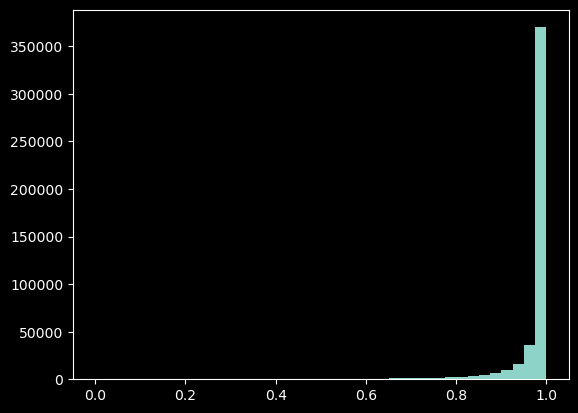

In [ ]:
plt.hist(triu_star_probs, bins=40)

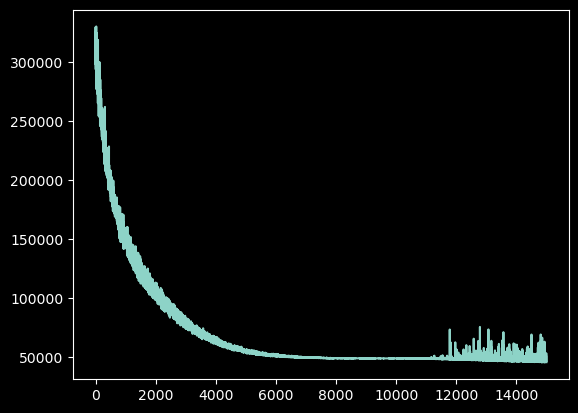

In [ ]:
plt.plot(svi_result.losses)

In [ ]:
from src.MWG_sampler import sample_posterior_triu_star

post_triu = jnp.array([])
for sch in range(data_dict["n_schools"]):
    sch_probs = triu_star_probs[data_dict["schid_edges"] == sch] 
    rng_key, _ = jax.random.split(rng_key)
    sch_triu = sample_posterior_triu_star(rng_key, sch_probs, 3000)
    post_triu = jnp.concatenate([post_triu, sch_triu], axis=1) if post_triu.size > 0 else sch_triu
    
print(post_triu.shape)

(3000, 466436)


In [ ]:
# N = data_dict["total_n"]

# @jax.jit
def triu_to_mat(triu, n):
    mat = jnp.zeros((n, n))
    mat = mat.at[np.triu_indices(n=n, k=1)].set(triu)
    return mat + mat.T

# @jax.jit
def compute_deg(triu, n):
    mat = triu_to_mat(triu, n)
    return jnp.sum(mat, axis=1)

vmap_deg = jax.vmap(compute_deg, in_axes=(0, None))



In [ ]:
# true_deg = compute_deg(data_dict["ST_triu"])
# stw2_deg = compute_deg(data_dict["STW2_triu"])
# bf_deg = compute_deg(data_dict["BF_triu"])
# bfw2_deg = compute_deg(data_dict["BFW2_triu"])


true_deg = jnp.array([])
stw2_deg = jnp.array([])
bf_deg = jnp.array([])
bfw2_deg = jnp.array([])
# post_deg = vmap_deg(post_triu)
post_deg = jnp.array([])
for sch in range(data_dict["n_schools"]):
    n_nodes = data_dict["n_nodes_sch"][sch]
    sch_triu = post_triu[:, data_dict["schid_edges"] == sch]
    sch_deg = vmap_deg(sch_triu, n_nodes)
    post_deg = jnp.concatenate([post_deg, sch_deg], axis=1) if post_deg.size > 0 else sch_deg

    sch_true_deg = compute_deg(data_dict["ST_triu"][data_dict["schid_edges"] == sch], n_nodes)
    true_deg = jnp.concatenate([true_deg, sch_true_deg]) if true_deg.size > 0 else sch_true_deg

    sch_stw2_deg = compute_deg(data_dict["STW2_triu"][data_dict["schid_edges"] == sch], n_nodes)  
    stw2_deg = jnp.concatenate([stw2_deg, sch_stw2_deg]) if stw2_deg.size > 0 else sch_stw2_deg

    sch_bf_deg = compute_deg(data_dict["BF_triu"][data_dict["schid_edges"] == sch], n_nodes)
    bf_deg = jnp.concatenate([bf_deg, sch_bf_deg]) if bf_deg.size > 0 else sch_bf_deg

    sch_bfw2_deg = compute_deg(data_dict["BFW2_triu"][data_dict["schid_edges"] == sch],n_nodes)
    bfw2_deg = jnp.concatenate([bfw2_deg, sch_bfw2_deg]) if bfw2_deg.size > 0 else sch_bfw2_deg

print(post_deg.shape, true_deg.shape, stw2_deg.shape, bf_deg.shape, bfw2_deg.shape)


# plt.scatter(true_deg, stw2_deg)


(3000, 1923) (1923,) (1923,) (1923,) (1923,)


cor ST and ST w2 0.4219026
cor ST and Post -0.012238568
cor ST and BF 0.41076398


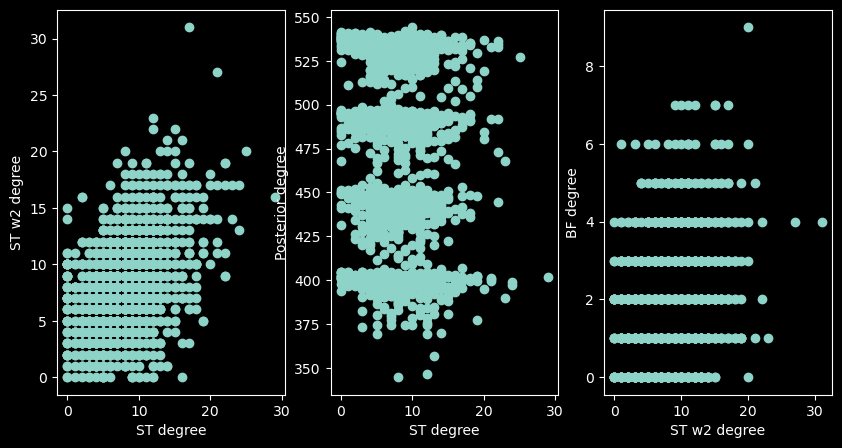

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].scatter(true_deg, stw2_deg)
axs[0].set_xlabel("ST degree")
axs[0].set_ylabel("ST w2 degree")

axs[1].scatter(true_deg, post_deg.mean(axis=0))
axs[1].set_xlabel("ST degree")
axs[1].set_ylabel("Posterior degree")

axs[2].scatter(stw2_deg, bf_deg)
axs[2].set_xlabel("ST w2 degree")
axs[2].set_ylabel("BF degree")

print("cor ST and ST w2", jnp.corrcoef(true_deg, stw2_deg)[0, 1])
print("cor ST and Post", jnp.corrcoef(true_deg, post_deg.mean(axis=0))[0, 1])
print("cor ST and BF", jnp.corrcoef(true_deg, bf_deg)[0, 1])

In [ ]:
# TODO: keep tinkering. options:
# 1. Run models with known st_triu values and perform posterior predictive checks for model fit
# 2. Run model with combined st_w2 and bf proxy networks -- think about these models form and prior p(ST) model 

In [37]:

def prior_model(data):

    n_cols = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([n_cols]))
   
    # alpha = numpyro.sample("alpha", dist.Normal(0.0, PRIOR_SCALE).expand([data["n_schools"]]))

    sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfNormal(3.0))
    alpha_sc = numpyro.sample("alpha_sc", dist.Normal(0.0, 1.0).expand([data["n_schools"]]))
    alpha = numpyro.deterministic("alpha", alpha_sc * sigma_alpha)

    # or for hierarchical modeling, you could do something like:
    # sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfCauchy(1.0))
    # alpha = numpyro.sample("alpha", dist.Normal(0.0, sigma_alpha).expand([S]))

    # -------------------------------------------------------
    #  3. Node-level latent positions, all schools concatenated
    # -------------------------------------------------------

    with numpyro.plate("all_nodes", data["total_n"]):
        # 1D array of length total_n
        u_all = numpyro.sample("u_all", dist.Normal(0.0, 1.0))

    # -------------------------------------------------------
    #  4. Compute star_probs = P(A^1_{ij}=1) for each edge
    # -------------------------------------------------------
    # We can compute "global" node indices for each edge in a vectorized manner:
    #   global_i[e] = offsets[schid[e]] + i_idx[e]
    #   global_j[e] = offsets[schid[e]] + j_idx[e]
    global_i = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 0]
    global_j = data["offsets"][data["schid_edges"]] + data["ij_indices"][:, 1]

    # The distance in latent space for edge e:
    #   dist_term[e] = | u_all[global_i[e]] - u_all[global_j[e]] |
    u_i = u_all[global_i]
    u_j = u_all[global_j]
    u_norm = jnp.abs(u_i - u_j)

    # The linear covariate predictor for edge e:
    #   cov_term[e] = dot(cov[e,:], theta)
    # cov_term = jnp.einsum('ed,d->e', data["cov"], theta)  # shape (E,)
    cov_term = jnp.dot(data["cov"], theta)

    # The school random intercept: alpha_term[e] = alpha[ schid[e] ]
    alpha_term = alpha[data["schid_edges"]]

    # Now combine them into the logit
    star_logit = alpha_term + cov_term - u_norm 
    star_probs = jax.nn.sigmoid(star_logit)  # shape (E,)
    star_probs = jnp.clip(star_probs, a_min=1e-6, a_max=1.0 - 1e-6)


    with numpyro.plate("edges", data["cov"].shape[0]):
        numpyro.sample("obs", dist.BernoulliProbs(star_probs), obs=data["ST_triu"])


# run model with svi 

# data_st_prior = {"ST_triu": st_net_triu,
#             "cov": df_min_net_cov,
#             "n" : df_min.shape[0]}

# init_vals = {
#     "theta": jnp.zeros(data_st_prior["cov"].shape[1]),
# }

# guide = AutoMultivariateNormal(prior_model)
guide = AutoLowRankMultivariateNormal(prior_model)
# guide = AutoNormal(prior_model)

svi = SVI(
    model=prior_model,
    guide=guide,
    optim=ClippedAdam(0.0005),
    loss=Trace_ELBO(),
)

rng_key = jax.random.PRNGKey(5)
rng_key, _ = jax.random.split(rng_key)

svi_result = svi.run(rng_key=rng_key,
                    num_steps=15000,
                    progress_bar=True,
                    data=data_dict,
                    # data=data_st_prior,
                    # init_params=init_vals
                    )

print(svi_result.params)


100%|██████████| 15000/15000 [06:13<00:00, 40.12it/s, init loss: 67500.8906, avg. loss [14251-15000]: 33928.1374]


{'auto_cov_factor': Array([[ 0.00377626, -0.05006949, -0.00783617, ..., -0.04329273,
         0.09193456, -0.02425844],
       [-0.00460365,  0.05063675,  0.00148339, ...,  0.0096317 ,
        -0.0220038 ,  0.01752291],
       [ 0.01449996, -0.00932784,  0.00392304, ...,  0.00591443,
         0.00641166, -0.0102822 ],
       ...,
       [-0.01763829, -0.03639995,  0.01770098, ...,  0.00066798,
        -0.01532276, -0.00828956],
       [ 0.01032049, -0.01375077, -0.01678369, ..., -0.00590886,
         0.00983776,  0.04155787],
       [-0.00182317,  0.00528317,  0.01654167, ..., -0.01764451,
         0.02691441, -0.00454473]], dtype=float32), 'auto_loc': Array([-3.8587751 ,  1.1854817 ,  0.28233337, ...,  2.4605129 ,
       -2.4461794 , -2.4560173 ], dtype=float32), 'auto_scale': Array([0.0225362 , 0.02208274, 0.02436074, ..., 0.6850642 , 0.6556156 ,
       0.6600643 ], dtype=float32)}


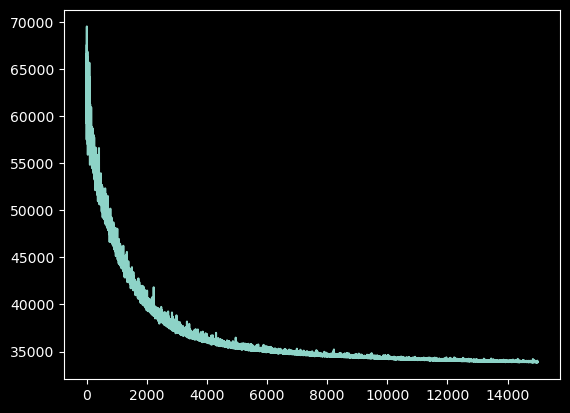

In [38]:
plt.plot(svi_result.losses)

In [39]:

# data_pred = {
#     "ST_triu": None,
#     "cov": df_min_net_cov,
#     "n" : df_min.shape[0]
# }

data_pred = data_dict.copy()
data_pred["ST_triu"] = None

rng_key, _ = jax.random.split(rng_key)
preds_st = Predictive(
    model=prior_model,
    guide=guide,
    params=svi_result.params,
    num_samples=3000,
)(rng_key, data_pred)["obs"]

print(preds_st.shape)

(3000, 466436)


In [40]:
post_deg = jnp.array([])
for sch in range(data_dict["n_schools"]):
    n_nodes = data_dict["n_nodes_sch"][sch]
    sch_triu = preds_st[:, data_dict["schid_edges"] == sch]
    sch_deg = vmap_deg(sch_triu, n_nodes)
    post_deg = jnp.concatenate([post_deg, sch_deg], axis=1) if post_deg.size > 0 else sch_deg

    
print(post_deg.shape,)



(3000, 1923)


cor ST and Post 0.6968443


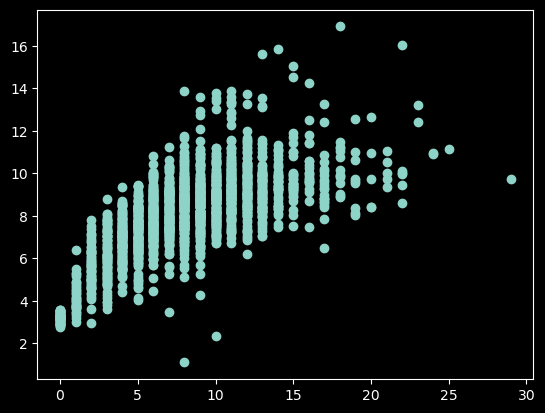

In [41]:
# vmap_pred_deg = vmap_deg(preds_st)
# true_deg = jnp.sum(st_net, axis=1)

plt.scatter(true_deg, post_deg.mean(axis=0))

print("cor ST and Post", jnp.corrcoef(true_deg, post_deg.mean(axis=0))[0, 1])

In [ ]:
# TODO: keep tinkering on multi-schools prior and combined models